In [ ]:
# ==============================================================================
# SKRIPSI: ANALISIS HUBUNGAN KEKERINGAN (SPI) DAN TITIK PANAS (HOTSPOT)
# Lokasi: Provinsi Jambi (2010-2020)
# Penulis: Jariyan Arifudin
# ==============================================================================

import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr, spearmanr
from google.colab import drive

In [ ]:
# ==============================================================================
# [1] KONFIGURASI LINGKUNGAN & PARAMETER
# ==============================================================================

# Setup Plotting Style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Mount Drive
drive.mount('/content/drive')

# Path Configuration
BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Skripsi'
ADMIN_PATH = os.path.join(BASE_PATH, 'Batas Adm Jambi/Adm_Jambi_Prov.shp')
CRS_TARGET = "EPSG:4326"

# Analysis Parameters
SPI_VARIANTS = [1, 3, 6, 12]
START_YEAR = 2010
END_YEAR = 2020

# Hotspot Data Paths (Dictionary Mapping)
HOTSPOT_PATHS = {
    year: os.path.join(BASE_PATH, f'NASA-FIRMS Fire (New2)/DL_FIRE_M-C61_{(587964 + (year-2011) if year < 2018 else 587976 + (year-2018))}_{year}/fire_archive_M-C61_*.shp')
    for year in range(START_YEAR, END_YEAR + 1)
}
# Catatan: Path di atas digeneralisasi. Jika nama folder tidak pola,
# gunakan dictionary manual seperti script sebelumnya.

# Manual path fallback jika pola di atas tidak sesuai folder asli:
HOTSPOT_PATHS = {
    2010: f'{BASE_PATH}/NASA-FIRMS Fire (New2)/DL_FIRE_M-C61_587963_2010/fire_archive_M-C61_587963.shp',
    2011: f'{BASE_PATH}/NASA-FIRMS Fire (New2)/DL_FIRE_M-C61_587964_2011/fire_archive_M-C61_587964.shp',
    2012: f'{BASE_PATH}/NASA-FIRMS Fire (New2)/DL_FIRE_M-C61_587966_2012/fire_archive_M-C61_587966.shp',
    2013: f'{BASE_PATH}/NASA-FIRMS Fire (New2)/DL_FIRE_M-C61_587967_2013/fire_archive_M-C61_587967.shp',
    2014: f'{BASE_PATH}/NASA-FIRMS Fire (New2)/DL_FIRE_M-C61_587968_2014/fire_archive_M-C61_587968.shp',
    2015: f'{BASE_PATH}/NASA-FIRMS Fire (New2)/DL_FIRE_M-C61_587970_2015/fire_archive_M-C61_587970.shp',
    2016: f'{BASE_PATH}/NASA-FIRMS Fire (New2)/DL_FIRE_M-C61_587971_2016/fire_archive_M-C61_587971.shp',
    2017: f'{BASE_PATH}/NASA-FIRMS Fire (New2)/DL_FIRE_M-C61_587972_2017/fire_archive_M-C61_587972.shp',
    2018: f'{BASE_PATH}/NASA-FIRMS Fire (New2)/DL_FIRE_M-C61_587976_2018/fire_archive_M-C61_587976.shp',
    2019: f'{BASE_PATH}/NASA-FIRMS Fire (New2)/DL_FIRE_M-C61_587977_2019/fire_archive_M-C61_587977.shp',
    2020: f'{BASE_PATH}/NASA-FIRMS Fire (New2)/DL_FIRE_M-C61_587978_2020/fire_archive_M-C61_587978.shp'
}

Mounted at /content/drive


In [ ]:
# ==============================================================================
# [2] FUNGSI UTILITAS (HELPER FUNCTIONS)
# ==============================================================================

def find_col_name(df, candidates):
    """Mencari nama kolom yang tersedia (Case Insensitive) untuk kompatibilitas data."""
    existing_cols = df.columns
    for cand in candidates:
        if cand in existing_cols: return cand
        for exist in existing_cols:
            if exist.lower() == cand.lower():
                return exist
    return None

def get_grouped_folder(year, spi_idx):
    """Menentukan nama folder berdasarkan pengelompokan tahun data."""

    # === PERBAIKAN DI SINI ===
    # Ubah range awal agar mengenali folder "2009-2011"
    # Logika ini akan mengarahkan tahun 2010 dan 2011 ke folder yang benar.
    if 2009 <= year <= 2011: range_str = "2009-2011"

    elif 2012 <= year <= 2013: range_str = "2012-2013"
    elif 2014 <= year <= 2015: range_str = "2014-2015"
    elif 2016 <= year <= 2017: range_str = "2016-2017"
    elif 2018 <= year <= 2020: range_str = "2018-2020"
    else: return None

    return f"Polygon_SPI{spi_idx}_{range_str}"

def fix_geometry(gdf):
    """Memperbaiki geometri topologi dan standarisasi CRS."""
    if gdf.crs is None:
        gdf = gdf.set_crs(CRS_TARGET)

    # Cek jika koordinat ribuan (indikasi UTM), konversi ke LatLong
    bounds = gdf.total_bounds
    if bounds[0] > 1000:
        gdf = gdf.set_crs("EPSG:32748", allow_override=True).to_crs(CRS_TARGET)
    else:
        gdf = gdf.to_crs(CRS_TARGET)

    # Perbaikan Topologi (Buffer 0) untuk menghindari error sjoin
    gdf['geometry'] = gdf.geometry.buffer(0)
    return gdf

In [ ]:
# ==============================================================================
# [3] EKSEKUSI UTAMA (MAIN LOOP ANALYSIS)
# ==============================================================================

print("[INIT] Memuat batas administrasi provinsi Jambi...")
jambi_gdf = gpd.read_file(ADMIN_PATH).to_crs(CRS_TARGET)
summary_stats = []

for spi_idx in SPI_VARIANTS:
    print(f"\n{'='*60}\n      MEMPROSES DATA: SPI-{spi_idx}\n{'='*60}")

    # A. Setup Target Column
    target_candidates = ['gridcode', 'GRIDCODE'] if spi_idx == 1 else ['class', 'CLASS', 'Class']
    print(f"[INFO] Target Kolom Atribut: {target_candidates}")

    # B. File Discovery Logic
    current_spi_paths = {}
    root_folder = f"SPI{spi_idx}-Output"

    for year in range(START_YEAR, END_YEAR + 1):
        for month in range(1, 13):
            key_id = int(f"{year}{month:02d}")

            if spi_idx == 1:
                sub_folder = os.path.join('Polygon_Class', str(year))
                candidates = [f'SPI-Poly_{year}{month:02d}.shp']
            else:
                grouped_folder = get_grouped_folder(year, spi_idx)
                if not grouped_folder: continue
                sub_folder = grouped_folder
                candidates = [f'SPI{spi_idx}-Poly_{year}{month:02d}.shp', f'SPI3-Poly_{year}{month:02d}.shp']

            found = False
            for fname in candidates:
                fpath = os.path.join(BASE_PATH, root_folder, sub_folder, fname)
                if os.path.exists(fpath):
                    current_spi_paths[key_id] = fpath
                    found = True
                    break

            # Debugging opsional jika file tidak ketemu (bisa di-uncomment)
            # if not found: print(f"[WARN] File tidak ditemukan untuk {year}-{month}")

    print(f"-> Total File Shapefile SPI ditemukan: {len(current_spi_paths)}")
    if len(current_spi_paths) == 0: continue

    # C. Spatial Processing Loop
    results = []

    for key_id, spi_path in current_spi_paths.items():
        year = int(str(key_id)[:4])
        month = int(str(key_id)[4:])

        hs_path = HOTSPOT_PATHS.get(year)
        if not hs_path or not os.path.exists(hs_path): continue

        try:
            # 1. Load & Fix SPI Data
            spi_gdf = gpd.read_file(spi_path)
            spi_gdf = fix_geometry(spi_gdf)
            col_target = find_col_name(spi_gdf, target_candidates)
            if not col_target: continue

            # 2. Load & Filter Hotspot Data
            hs_gdf = gpd.read_file(hs_path)
            col_conf = find_col_name(hs_gdf, ['confidence', 'CONFIDENCE'])
            col_date = find_col_name(hs_gdf, ['acq_date', 'ACQ_DATE'])

            if not col_date: continue

            # Filter Confidence Level >= 80% (High Confidence)
            if col_conf:
                hs_gdf = hs_gdf[hs_gdf[col_conf] >= 80]

            # Filter by Month
            hs_gdf['date_parsed'] = pd.to_datetime(hs_gdf[col_date], errors='coerce')
            hs_month = hs_gdf[hs_gdf['date_parsed'].dt.month == month]
            if hs_month.empty: continue

            # 3. Spatial Operations
            if hs_month.crs != CRS_TARGET:
                hs_month = hs_month.to_crs(CRS_TARGET)

            # Clip Hotspot to Jambi Boundary
            hs_ready = gpd.clip(hs_month, jambi_gdf)
            if hs_ready.empty: continue

            # Spatial Join (Intersect)
            joined = gpd.sjoin(hs_ready, spi_gdf[['geometry', col_target]], how='inner', predicate='intersects')

            if not joined.empty:
                # Aggregate Counts
                temp_res = joined[col_target].value_counts().reset_index()
                temp_res.columns = ['SPI_Class', 'Hotspot_Count']
                temp_res['Year'] = year
                temp_res['Month'] = month
                results.append(temp_res)

        except Exception as e:
            print(f"[ERROR] Gagal memproses {key_id}: {str(e)}")
            continue

    # D. Statistical Calculation per SPI Variant
    if not results:
        print(f"[FAIL] Tidak ada irisan data untuk SPI-{spi_idx}")
        continue

    # Agregasi Total
    results_df = pd.concat(results, ignore_index=True)
    # Group by Year-Month-Class to handle duplicates/splits
    results_df = results_df.groupby(['Year', 'Month', 'SPI_Class'], as_index=False)['Hotspot_Count'].sum()
    results_df['SPI_Numeric'] = pd.to_numeric(results_df['SPI_Class'], errors='coerce')
    results_df.dropna(subset=['SPI_Numeric'], inplace=True) # Bersihkan non-numeric

    # Save Intermediate CSV
    out_csv = os.path.join(BASE_PATH, f'Hasil_Hotspot_SPI{spi_idx}_2011-2020.csv')
    results_df.to_csv(out_csv, index=False)

    # Hitung Korelasi
    if len(results_df) > 5:
        r_val, p_val_p = pearsonr(results_df['Hotspot_Count'], results_df['SPI_Numeric'])
        rho, p_val_s = spearmanr(results_df['Hotspot_Count'], results_df['SPI_Numeric'])

        significance = 'Ya' if p_val_s < 0.05 else 'Tidak'

        summary_stats.append({
            'SPI_Index': f'SPI-{spi_idx}',
            'Rho': rho,
            'P_Value': p_val_s,
            'Signifikan': significance
        })

        print(f"[HASIL] SPI-{spi_idx} | Spearman Rho: {rho:.4f} | p-value: {p_val_s:.4e} ({significance})")

        # Optional: Scatterplot per SPI (untuk pemeriksaan detail)
        # plt.figure(figsize=(6, 4))
        # sns.regplot(x='Hotspot_Count', y='SPI_Numeric', data=results_df, color='firebrick')
        # plt.title(f'Scatter: SPI-{spi_idx} vs Hotspot')
        # plt.show()

[INIT] Memuat batas administrasi provinsi Jambi...

      MEMPROSES DATA: SPI-1
[INFO] Target Kolom Atribut: ['gridcode', 'GRIDCODE']
-> Total File Shapefile SPI ditemukan: 132
[HASIL] SPI-1 | Spearman Rho: 0.2802 | p-value: 2.0538e-04 (Ya)

      MEMPROSES DATA: SPI-3
[INFO] Target Kolom Atribut: ['class', 'CLASS', 'Class']
-> Total File Shapefile SPI ditemukan: 132
[HASIL] SPI-3 | Spearman Rho: 0.4413 | p-value: 6.4619e-09 (Ya)

      MEMPROSES DATA: SPI-6
[INFO] Target Kolom Atribut: ['class', 'CLASS', 'Class']
-> Total File Shapefile SPI ditemukan: 132
[HASIL] SPI-6 | Spearman Rho: 0.2397 | p-value: 3.2358e-03 (Ya)

      MEMPROSES DATA: SPI-12
[INFO] Target Kolom Atribut: ['class', 'CLASS', 'Class']
-> Total File Shapefile SPI ditemukan: 132
[HASIL] SPI-12 | Spearman Rho: 0.1073 | p-value: 1.7399e-01 (Tidak)



VISUALISASI PERBANDINGAN KORELASI (SPEARMAN)
[INFO] File rekap disimpan di: /content/drive/My Drive/Colab Notebooks/Skripsi/Rekap_Korelasi_All_SPI_Final.csv


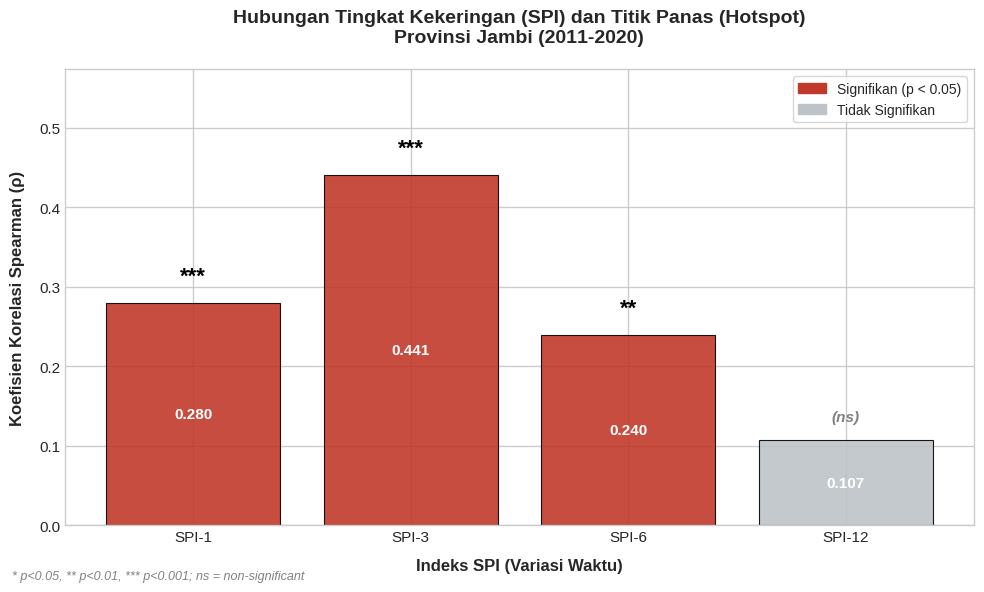

In [ ]:
# ==============================================================================
# [4] VISUALISASI FINAL (SUMMARY BAR CHART)
# ==============================================================================

print("\n" + "="*50)
print("VISUALISASI PERBANDINGAN KORELASI (SPEARMAN)")
print("="*50)

if summary_stats:
    # Menggunakan hasil perhitungan otomatis (bukan hardcoded)
    df_viz = pd.DataFrame(summary_stats)

    # Simpan Rekapitulasi ke CSV
    rekap_csv = os.path.join(BASE_PATH, 'Rekap_Korelasi_All_SPI_Final.csv')
    df_viz.to_csv(rekap_csv, index=False)
    print(f"[INFO] File rekap disimpan di: {rekap_csv}")

    # --- Mulai Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    # Warna Dinamis: Merah jika Signifikan, Abu-abu jika Tidak
    colors = ['#c0392b' if sig == 'Ya' else '#bdc3c7' for sig in df_viz['Signifikan']]

    # Plotting Bar
    bars = ax.bar(df_viz['SPI_Index'], df_viz['Rho'], color=colors, edgecolor='black', linewidth=0.8, alpha=0.9)

    # Fungsi Helper untuk Label Bintang Signifikansi
    def get_stars(p):
        if p < 0.001: return '***'
        elif p < 0.01: return '**'
        elif p < 0.05: return '*'
        else: return 'ns'

    # Menambahkan Label Angka & Bintang
    for bar, rho, p in zip(bars, df_viz['Rho'], df_viz['P_Value']):
        height = bar.get_height()
        stars = get_stars(p)

        # Label Angka di tengah batang
        ax.text(bar.get_x() + bar.get_width()/2., height/2,
                f'{rho:.3f}',
                ha='center', va='center', color='white', fontweight='bold', fontsize=11)

        # Label Bintang di atas batang
        offset = 0.02
        color_star = 'black' if stars != 'ns' else 'grey'
        font_star = 16 if stars != 'ns' else 11
        style_star = 'normal' if stars != 'ns' else 'italic'
        text_label = stars if stars != 'ns' else '(ns)'

        ax.text(bar.get_x() + bar.get_width()/2., height + offset,
                text_label,
                ha='center', va='bottom', color=color_star,
                fontsize=font_star, fontweight='bold', style=style_star)

    # Formatting Sumbu & Judul
    ax.set_xlabel('Indeks SPI (Variasi Waktu)', fontsize=12, fontweight='bold', labelpad=10)
    ax.set_ylabel('Koefisien Korelasi Spearman (ρ)', fontsize=12, fontweight='bold', labelpad=10)
    ax.tick_params(axis='both', which='major', labelsize=11)

    ax.set_title('Hubungan Tingkat Kekeringan (SPI) dan Titik Panas (Hotspot)\nProvinsi Jambi (2011-2020)',
                 fontsize=14, fontweight='bold', pad=20)

    # Atur batas Y agar bintang tidak terpotong (dinamis + 10%)
    ax.set_ylim(0, df_viz['Rho'].max() * 1.3)

    # Legenda Custom
    legend_sig = mpatches.Patch(color='#c0392b', label='Signifikan (p < 0.05)')
    legend_ns = mpatches.Patch(color='#bdc3c7', label='Tidak Signifikan')
    ax.legend(handles=[legend_sig, legend_ns], loc='upper right', fontsize=10, frameon=True)

    # Footer Note
    plt.figtext(0.02, 0.02,
                '* p<0.05, ** p<0.01, *** p<0.001; ns = non-significant',
                fontsize=9, color='grey', style='italic')

    plt.tight_layout()
    plt.show()

else:
    print("[WARN] Tidak ada data statistik yang dihasilkan. Periksa path file atau proses analisis.")